In [94]:
import pandas as pd
import numpy as np
import gc

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

from dateutil.relativedelta import relativedelta

In [2]:
train = pd.read_csv("new_train.csv", parse_dates=["date"], dtype={"Page": str, "Visits": 'float32'})
train = train.loc[(train["date"] >= '2016-03-01') & (train["date"] <= '2016-08-31')]
train.fillna(0, inplace=True)
test = pd.read_csv("new_test.csv", parse_dates=["date"], dtype={"Page": str, "Visits": 'float32'})
test.fillna(0, inplace=True)
train["Visits"] = np.log1p(train["Visits"]).astype("float64")
test["Visits"] = np.log1p(test["Visits"]).astype("float64")

In [9]:
def create_features(df, month, target=None):
    if type(target) != type(pd.DataFrame()):
        target = df.loc[(df["date"] >= pd.to_datetime(month)) & (df["date"] <= pd.to_datetime(month) + relativedelta(months=2))]
    temp = df.loc[(train["date"] < pd.to_datetime(month) + relativedelta(days=-10)) & (df["date"] >= pd.to_datetime(month) + relativedelta(days=-40))].copy()
    print(temp["date"].min(), temp["date"].max())
    temp = pd.pivot_table(temp,index=["Page"], values=["Visits"], columns=["date"]).reset_index()
    temp.columns = ["lag_{}".format(i)  if j[1] != "" else j[0] for i, j in enumerate(temp.columns)]

    temp = target.merge(temp, on="Page", how='left')

    temp['Month']     = temp["date"].dt.month
    temp['Month']     = temp['Month'] - temp['Month'].min()
    temp['Day']       = temp["date"].dt.day
    temp['DayOfWeek'] = temp["date"].dt.dayofweek
    return temp
    

In [10]:
new_train = create_features(train, '2016-04-10')
new_val = create_features(train, '2016-06-10')

2016-03-01 00:00:00 2016-03-30 00:00:00
2016-05-01 00:00:00 2016-05-30 00:00:00


In [11]:
train_cols = [ 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
               'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
               'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
               'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26',
               'lag_27', 'lag_28', 'lag_29', 'lag_30', 'Month', 'Day', 'DayOfWeek']

In [12]:
print("Train:      {} - {}".format(str(new_train["date"].min())[:10], str(new_train["date"].max())[:10]))
print("Validation: {} - {}".format(str(new_val["date"].min())[:10], str(new_val["date"].max())[:10]))

Train:      2016-04-10 - 2016-06-10
Validation: 2016-06-10 - 2016-08-10


In [13]:
import lightgbm as lgb
param = {}
param['application'] = 'regression_l2'
param['learning_rate'] = 0.1
param['feature_fraction'] = 0.5
param['bagging_fraction'] = 0.5
param['bagging_freq'] = 1
param['max_depth'] = 5
param['num_threads'] = 4

from numba import jit
import math

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def lgb_smape(preds, df):
    labels = df.get_label()
    labels, preds = np.expm1(np.array(labels)), np.expm1(np.array(preds))
    return 'mape', smape_fast(labels, preds), False

In [14]:
lgb_train = lgb.Dataset(new_train[train_cols], label=new_train["Visits"], free_raw_data=False)
lgb_val = lgb.Dataset(new_val[train_cols], label=new_val["Visits"], free_raw_data=False, reference=lgb_train)

model = lgb.train(param, lgb_train, 1000, valid_sets=[lgb_train,lgb_val], feval=lgb_smape, early_stopping_rounds=10)

[1]	training's mape: 121.956	valid_1's mape: 119.772
Training until validation scores don't improve for 10 rounds.
[2]	training's mape: 115.947	valid_1's mape: 113.564
[3]	training's mape: 109.993	valid_1's mape: 107.456
[4]	training's mape: 104.183	valid_1's mape: 101.524
[5]	training's mape: 98.5583	valid_1's mape: 95.7734
[6]	training's mape: 93.2035	valid_1's mape: 90.3843
[7]	training's mape: 88.1463	valid_1's mape: 85.3463
[8]	training's mape: 83.43	valid_1's mape: 80.7541
[9]	training's mape: 79.0581	valid_1's mape: 76.5461
[10]	training's mape: 75.052	valid_1's mape: 72.6907
[11]	training's mape: 71.4198	valid_1's mape: 69.299
[12]	training's mape: 68.1453	valid_1's mape: 66.3337
[13]	training's mape: 65.2337	valid_1's mape: 63.6829
[14]	training's mape: 62.653	valid_1's mape: 61.4007
[15]	training's mape: 60.3763	valid_1's mape: 59.4189
[16]	training's mape: 58.4096	valid_1's mape: 57.7731
[17]	training's mape: 56.7168	valid_1's mape: 56.3949
[18]	training's mape: 55.2671	vali

In [45]:
gc.collect()

950

## Feature importance

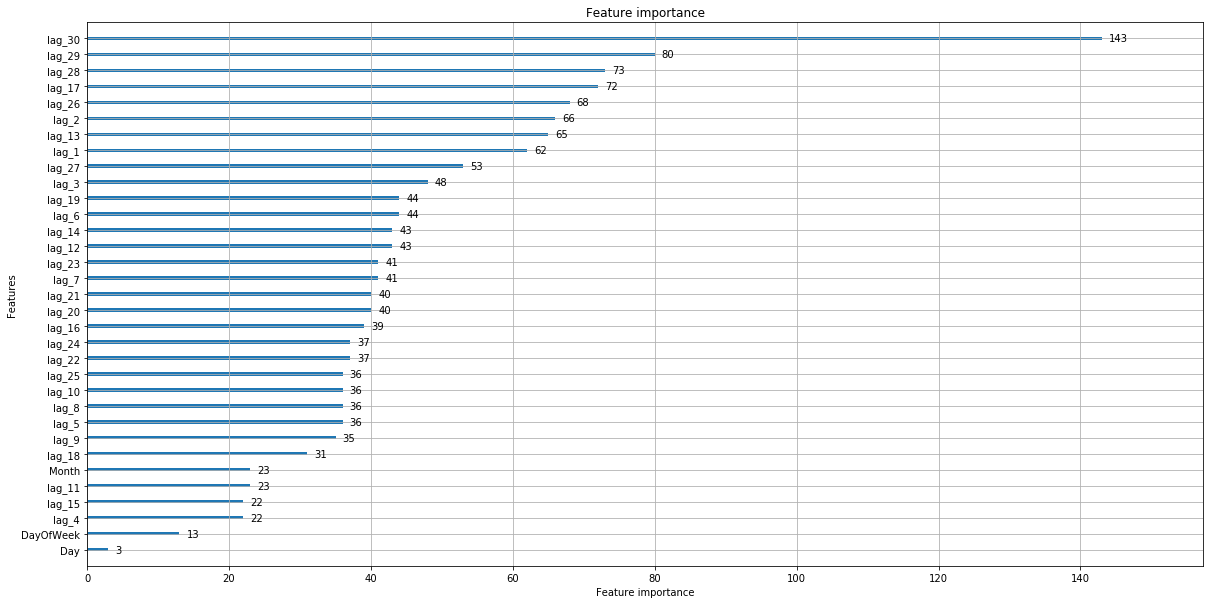

In [20]:
lgb.plot_importance(model, figsize=(20, 10))

## Analyze predictions

In [22]:
predictions = model.predict(new_val[train_cols])

In [26]:
new_val['prediciton'] = predictions

In [159]:
new_train['Real_Visits'] = np.expm1(new_train['Visits'])

In [30]:
new_val['Real_Visits'] = np.expm1(new_val['Visits'])
new_val['Real_Prediction'] = np.expm1(new_val['prediciton'])

### SMAPE distributions

In [134]:
df_smape = pd.DataFrame(new_val.groupby(['Page']).apply(lambda x: smape_fast(np.array(x['Real_Visits']), np.array(x['Real_Prediction']))))
df_smape.columns = ['smape']

In [290]:
df_median = pd.DataFrame(new_val.groupby(['Page'])['Real_Visits'].median())
df_median.columns = ['median']

In [293]:
rez = new_val.set_index('Page').join(df_median).join(df_smape)

In [295]:
thresholds = [0, 10, 50, 250, 1000]

In [311]:
for i in range(len(thresholds)):
    if i == len(thresholds) -1:
        print('[%i, %s] = %f' % (thresholds[i],  'max', rez[rez['median'] >= thresholds[i]]['smape'].mean()))
    else:
        print('[%i, %i] = %f' % (thresholds[i],  thresholds[i+1], rez[(rez['median'] >= thresholds[i]) & (rez['median'] < thresholds[i + 1])]['smape'].mean()))

[0, 10] = 63.733281
[10, 50] = 48.123513
[50, 250] = 48.780230
[250, 1000] = 43.235584
[1000, max] = 42.566796


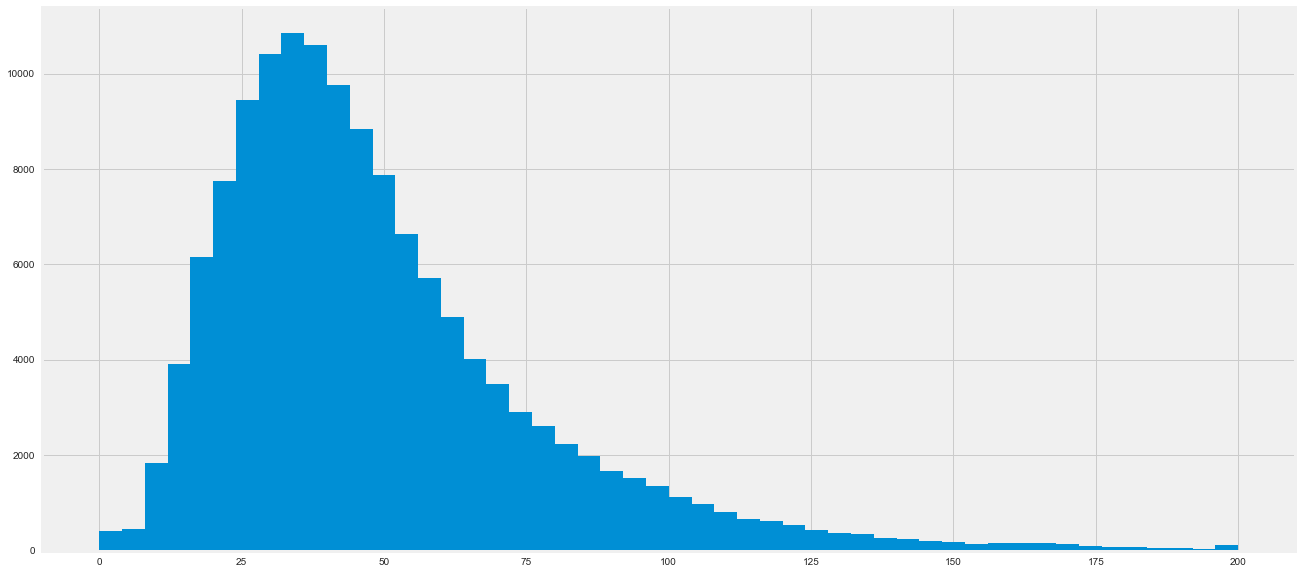

In [169]:
df_smape['smape'].hist(figsize=(20,10), bins=50)

### Predictions with biggest SMAPE

In [325]:
df_smape[df_smape < 200].sort_values('smape', ascending=False)[:5]

,smape
Page,
Especial:Entrar/signup_es.wikipedia.org_all-access_all-agents,199.982318
Cheryl_(entertainer)_en.wikipedia.org_all-access_all-agents,199.970585
2016_Wimbledon_Championships_en.wikipedia.org_all-access_all-agents,199.966682
Fast_8_es.wikipedia.org_all-access_all-agents,199.951375
2016_Wimbledon_Championships_en.wikipedia.org_desktop_all-agents,199.912401


In [326]:
# query = ["File:CarpetfromBagdad.jpg_commons.wikimedia.org_mobile-web_all-agents"]
query = df_smape[df_smape < 199].sort_values('smape', ascending=False)[:5].index.tolist()

In [327]:
feature = new_val[new_val['Page'].isin(query)]
past = new_train[new_train['Page'].isin(query)]

In [328]:
all_data = pd.concat([past, feature], axis=0)
all_data.set_index('date', inplace=True)

Ishqbaaz_en.wikipedia.org_all-access_all-agents


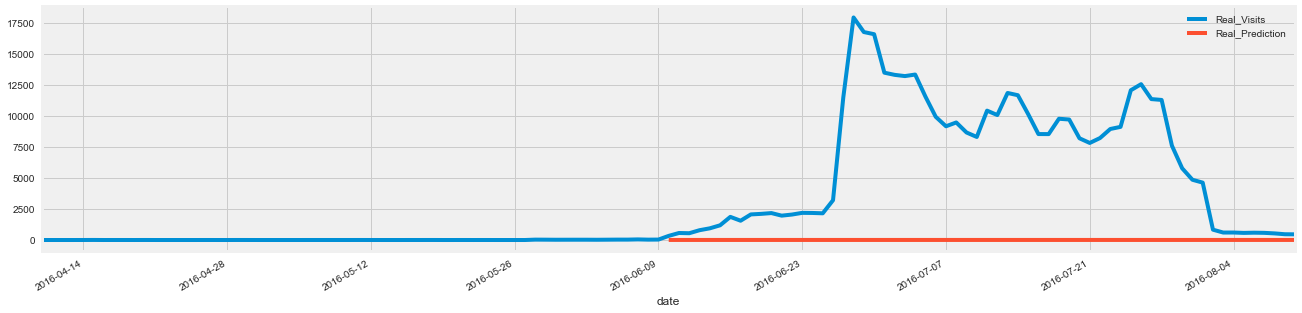

Olympische_Sommerspiele_2016/Teilnehmer_(Deutschland)_de.wikipedia.org_all-access_all-agents


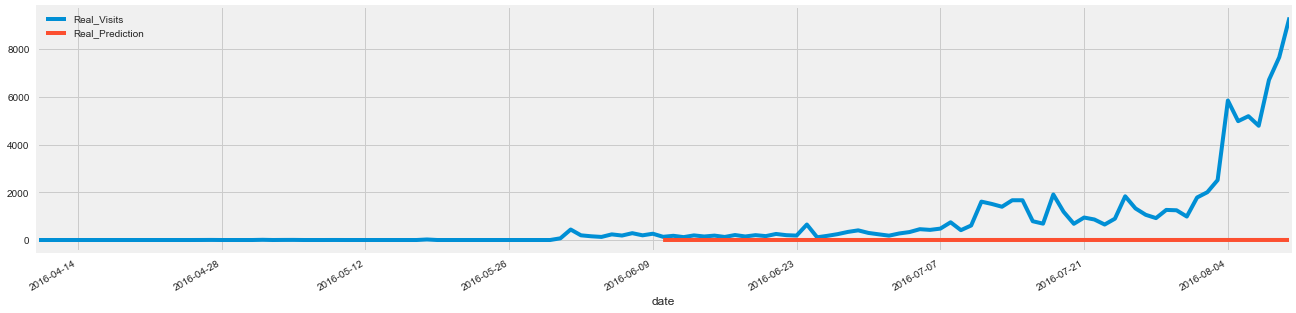

Olympische_Sommerspiele_2016/Teilnehmer_(Deutschland)_de.wikipedia.org_desktop_all-agents


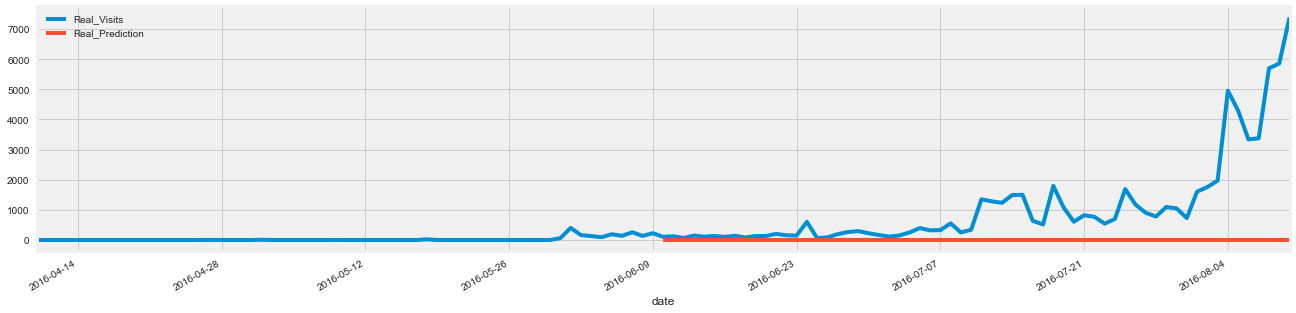

Volac_es.wikipedia.org_mobile-web_all-agents


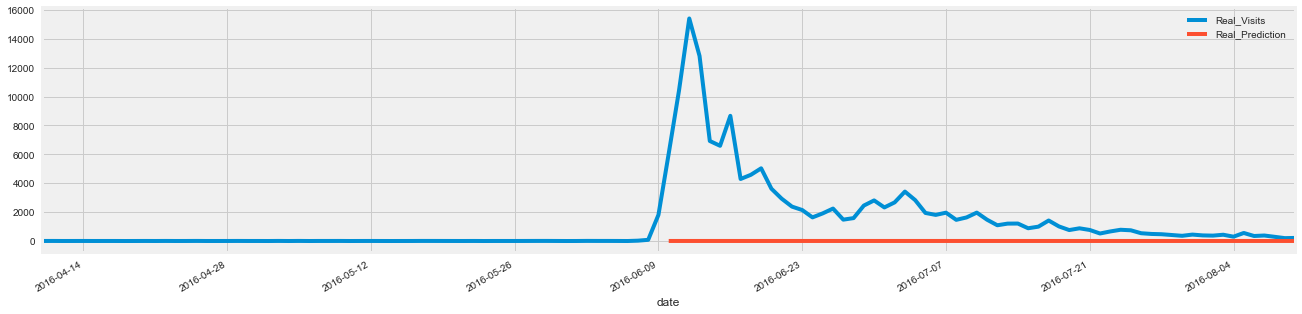

WWE_2K17_en.wikipedia.org_mobile-web_all-agents


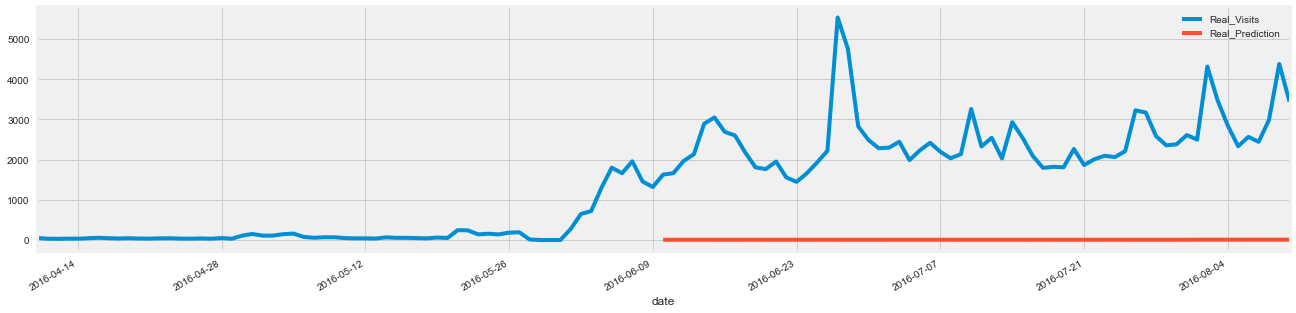

In [329]:
for name, data in all_data.groupby(['Page']):
    print(name)
    data[['Real_Visits', 'Real_Prediction']].plot(figsize=(20,5), label='Page')
    plt.legend(loc='best')
    plt.show()